# Question 2: Natural Language Processing

### Total Points: 46

### Background:
In this question you will fit a set of models with the goal of predicting which text messages (SMS) are spam and which are not. 

You will be experimenting with a variety of different embedding algorithms followed by Logistic Regression.

## Data Loading, Exploratory Data Analysis and Vocabulary Creation:


In [2]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from typing import List
import numpy as np 
import pandas as pd
from tqdm import tqdm
import torch
np.random.seed(42)

In [3]:
dataset = load_dataset("sms_spam")
texts = [x["sms"] for x in dataset["train"]]
labels = [x["label"] for x in dataset["train"]]

Reusing dataset sms_spam (C:\Users\Dell\.cache\huggingface\datasets\sms_spam\plain_text\1.0.0\53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
X_train, X_m, y_train, y_m = train_test_split(texts, labels, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_m, y_m, test_size = 0.5, random_state=0)

In [5]:
def tokenize(x:str) -> List[str]:
  """
  Takes string as an input and returns a list of tokens. This just splits the string x on whitespace
  """
  return x.lower().split(" ")

## [ 5 points ] Q2.a: Determine / Answer the following: 

*   How many datapoints are in the training set?






In [6]:
datapoints = len(X_train)
print(f'The number of datapoints in the training set is ' + str(datapoints))

The number of datapoints in the training set is 3901


*   How many total tokens are there in the data?

In [7]:
total_tokens = sum([len(tokens) for tokens in [tokenize(text) for text in texts]])
print(f'The number of datapoints in the training set is ' + str(total_tokens))

The number of datapoints in the training set is 87535


*   What % of training examples are spam?

In [9]:
spam_training = round(sum(y_train)/len(y_train), 4)*100
print(f'The number of datapoints in the training set is ' + str(spam_training) + '%')

The number of datapoints in the training set is 12.950000000000001%


*   What would the accuracy be if for every datapoint we predict it is spam? (explain)

In [13]:
test_spam = sum(y_test)/len(y_test)
accuracy = round(test_spam, 4)

In [14]:
print('If we were to predict spam for every datapoint, then the accuracy of our model would be ' + str(accuracy*100) +
      '% because that`s the percentage of spam datapoints in the test dataset.')

If we were to predict spam for every datapoint, then the accuracy of our model would be 16.37% because that`s the percentage of spam datapoints in the test dataset.


## [4 points ] Q2.b Vocabulary and Frequencies  

Implement the functions `create_count_dict`, and `create_vocab` below that take as input a dataset (list of untokenized strings - one per datapoint), and an integer representing the desired vocabulary size, and returns the vocabulary as a `dict` whose keys are tokens and whose values are indices.

In [15]:
def create_count_dict(dataset:List[str]) -> dict:
    """
    Given a dataset, returns a dictionary of token counts with tokens being keys, and counts being values
    """
    count_dict = {}
    
    # TODO
    tokens = []
    for text in dataset:
        tokens = tokens + tokenize(text)

    for token in set(tokens):
        count_dict[token] = tokens.count(token)

    return count_dict

def create_vocab(dataset:List[str], vocab_size:int) -> dict:
    """
    Given a dataset, returns a dictionary with tokens as keys and indices as values.

    {"token_1": 1, "token_2": 2, ...}
    """

    # TODO: 
    # 1. Determine the count of all words
    count_dict = create_count_dict(dataset)
    
    # 2. Keep the top <vocab_size> tokens
    top_tokens = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)[:vocab_size]
    
    # 3. Create the token to index dict and fill it with just the top tokens
    vocab_to_index_dict = {}
    
    i = 0
    for token, counts in top_tokens:
        vocab_to_index_dict[token] = i
        i += 1

    return vocab_to_index_dict

In [16]:
# Helper test to at least ensure the constructed vocab is the right size
for i in np.random.randint(low = 100, high = 500, size = 5):
    assert(len(create_vocab(X_train, vocab_size = i)) == i)

In [17]:
# Create and save your vocab
student_created_count_dict = create_count_dict(X_train)
student_created_vocab = create_vocab(X_train, vocab_size = 500)

## [4 points] Q2.c Token Counts

### Q2.c.a  Is the distribution of token counts below a relatively heavy-tailed distribution?  Would using only the top 30 tokens be sufficient for most applications?

The distribution of token counts has a heavy (slowly decaying) tail, using 30 words probably won't be sufficient for most applications, especially because most of the top tokens are stopwords

In [18]:
def visualize_top_token_distribution(count_dict, num_tokens_to_plot):
    """
    Display a barplot of counts of top <num_tokens_to_plot> tokens in the <count_dict>
    """
    df = pd.DataFrame(data={"token": [key for key, _ in count_dict.items()], "count": [value for _, value in count_dict.items()]}).sort_values("count", ascending=False)
    df[:num_tokens_to_plot].plot(x = "token", y = "count", kind="bar")

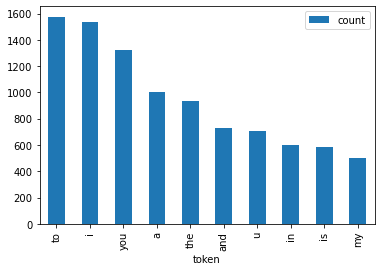

In [19]:
visualize_top_token_distribution(student_created_count_dict, 10)

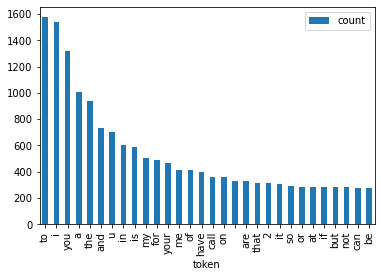

In [20]:
visualize_top_token_distribution(student_created_count_dict, 30)

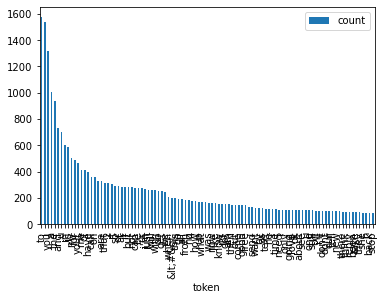

In [21]:
visualize_top_token_distribution(student_created_count_dict, 100)

### Q2.c.b [2 points] Take a look at the top 10 tokens in the plot above, do you think the embeddings based on those tokens will be informative for our task?


YOUR ANSWER HERE

Those words are incredibly common in any text in English (stopwords) and do not contribute to our task in terms of distinguishing between normal text and spam.

## Q2.d [ 13 points ] Vocabulary selection and Embeddings

In [22]:
# NOTHING TO DO HERE, JUST SOME CONVENIENCE FUNCTIONS FOR THE FUTURE
def index_to_token(index:int, vocabulary:dict) -> str:
    """
    Given an index in the vocabulary, and the vocabulary dict with tokens as keys, and indices as values, returns the token that maps to the given index
    """
    if index > len(vocabulary):
        raise ValueError(f"There is no index {index} in the vocabulary")
    inv_vocabulary = {v: k for k, v in vocabulary.items()}
    return inv_vocabulary[index]

def token_to_index(token:str, vocabulary:dict) -> int:
    """
    Given a token, return the index of that token in the vocabulary
    """
    index = vocabulary.get(token)
    if index is None:
        raise ValueError(f"Token: {token} is not in the vocabulary")
    return index

In [23]:
## NOTHING TO DO HERE

# BoW with our vocab
vectorizer_ours = CountVectorizer(max_features=500, tokenizer=tokenize, vocabulary=student_created_vocab) # Automatic BoW embeddings using your vocab
vectorized_data_ours = vectorizer_ours.fit_transform(X_train) # Embedded data

# Bow with an auto vocab
vectorizer_auto = CountVectorizer(max_features=500) # Automatic BoW embeddings and automatic vocab
vectorized_data_auto = vectorizer_auto.fit_transform(X_train) # Embedded data
VOCAB = vectorizer_auto.vocabulary_ # For convenience

# binary BoW
vectorizer_bbow = CountVectorizer(max_features=500, binary=True, vocabulary=VOCAB) # Automatic binary BoW embeddings using the automatically generated vocab above
vectorized_data_bbow = vectorizer_bbow.fit_transform(X_train) # Embedded data

# TFIDF
tfidf_transformer = TfidfTransformer(smooth_idf=False) # TF-IDF transformer for BoW embeddings
vectorized_data_tfidf_auto = tfidf_transformer.fit_transform(vectorized_data_auto) # Embedded data

### Q2.d.a [ 2 points ] Implement the function `vocabulary_diff` below. It should return a list of tokens that are in `vocab_1` but not in `vocab_2`.

In [24]:
# Get the differences between our vocabulary and the automatically generated one

def vocabulary_diff(vocab_1:dict, vocab_2:dict) -> List[str]:
    """
    Given 2 vocabularies, returns all the tokens that are present in vocab_1 but not in vocab_2
    """
    vocab_diff = [token for token in vocab_1.keys() if token not in vocab_2.keys()]
    return vocab_diff


print(vocabulary_diff(student_created_vocab,VOCAB))
print(vocabulary_diff(VOCAB, student_created_vocab))

['i', 'a', 'u', '', '2', "i'm", '&lt;#&gt;', '4', '.', '\n', 'r', '?', 'ü', "i'll", "don't", '...', 'n', '&', "it's", '&amp;', 'd', 'e', '-', 'c', '1', "can't", 'me.', 'you.', 'now!', 'now.', 'b', "i've", "that's", '3', "you're", '!', 'lor.', '?\n', 'you,', 'sorry,', ':)\n', "didn't", '*', 'u.', 'urgent!', 'day.', 'k', 'y', 'later\n', "he's", 'me.\n', 'it,', '£1000', 'you!', '5', "how's", 'ok.', 'v', 'lor...', 'you\n', '+', 'it.', 'no.', ',', 'x', 'tomorrow\n', 'lor...\n', '£100', 'i.ll', 'it.\n', 'lor.\n', 'juz', 'wif', 'g', 'makes', '£500', "we're", 'day.\n', 'me\n', 'yeah,', "there's", "won't", 'saying', '.\n', 'stay', 'home.', 'took', 'now.\n', 'you.\n', '&lt;decimal&gt;', 'wil', '6', 'needs']
['pa', 'yet', 'liao', 'lt', 'gt', 'www', 'com', 'wk', '150p', '16', 'min', 'feeling', 'apply', '18', 'ah', 'plan', 'll', 'princess', 'lar', 've', 'code', '10', 'tmr', 'don', '000', 'didn', 'bus', 'kiss', 'online', 'hours', 'haha', 'amp', 'evening', 'line', 'true', 'haven', 'sir', 'month', 'pr

###  Q2.d.b [3 points] Based on the differences between the two vocabularies, which do you think will represent our datapoints better? Why? 

YOUR ANSWER HERE

I think that the VOCAB vocabulary that was created using automatic BoW embeddings represent the datapoints better. First, because in our vocabulary there are too many stopwords like 'i', 'a', 'i've', 'it's' which we can see above. Secondly, it looks like the autovocabulary managed to avoid tokenizing symbols and words followed by symbols like '.', '-', '+', 'it.\n' or '&lt;decimal&gt;'

In [25]:
# Some convenience constants
DOCUMENT_COUNTS = np.bincount(vectorized_data_bbow.indices, minlength=vectorized_data_bbow.shape[1])
NUM_DATAPOINTS = len(X_train)
VOCAB = vectorizer_auto.vocabulary_

### Q2.d.c [3 points] Implement the `idf` function below which returns the inverse document frequency of a given word as defined by:

$$ IDF(w_j) = log(\frac{N}{N_j}) + 1 $$

where:

* $N$ is the number of datapoints 

* $N_j$ is the number of occurences of word $w_j$ in the data

In [26]:
def idf(word:str, document_count:np.ndarray=DOCUMENT_COUNTS, 
        num_datapoints:int=NUM_DATAPOINTS, vocabulary:dict=VOCAB) -> float:
    """
    returns the inverse document frequency of a particular word, based on the IDF definition of

    IDF(w_j) = log(N / N_j) + 1

    """
    # TODO
    N = num_datapoints
    N_j = document_count[token_to_index(word, vocabulary)]
    return np.log(N/N_j) + 1
    
#     pass

In [27]:
for index in np.random.randint(0,500, size=15).tolist():
    print(f"word: {index_to_token(index, VOCAB)}")
    print(f"your idf: {idf(index_to_token(index, VOCAB))}")
    print(f"calculated idf: {tfidf_transformer.idf_[index]}")
    assert np.isclose(tfidf_transformer.idf_[index], idf(index_to_token(index, VOCAB)))

word: head
your idf: 6.4357748654504405
calculated idf: 6.4357748654504405
word: ah
your idf: 6.224465771783233
calculated idf: 6.224465771783233
word: customer
your idf: 5.713640148017243
calculated idf: 5.713640148017243
word: dont
your idf: 4.684020730836085
calculated idf: 4.684020730836085
word: where
your idf: 4.862268962242403
calculated idf: 4.862268962242403
word: it
your idf: 3.2216160304603783
calculated idf: 3.2216160304603783
word: po
your idf: 6.0909343791587105
calculated idf: 6.0909343791587105
word: weekend
your idf: 6.177945756148341
calculated idf: 6.177945756148341
word: co
your idf: 5.60542656337701
calculated idf: 5.60542656337701
word: sms
your idf: 5.685469271050547
calculated idf: 5.685469271050547
word: could
your idf: 5.742627684890495
calculated idf: 5.742627684890495
word: service
your idf: 5.58010875539272
calculated idf: 5.58010875539272
word: forgot
your idf: 6.133493993577507
calculated idf: 6.133493993577507
word: easy
your idf: 6.273255935952665
calcu

### Q2.d.d [2 points] Implement a binary Bag of Words embedding function that takes in a list of token and a vocab, and returns a numpy array corresponding to the embedding vector

In [28]:
def binary_BoW_embedder(list_of_tokens:List[str], vocab:dict) -> np.ndarray:
    """
    Creates a binary Bag of Words embedding of a datapoint represented as a list of tokens, using the vocab
    """
    # Hint: you may want to start with np.zeros()
    
    embedding = np.zeros(len(vocab))
    
    for token in list_of_tokens:
        index_token = vocab[token]
        embedding[index_token] = 1 

    return embedding

In [29]:
for test_num in range(15):
    sample_token_indices = np.random.randint(0,500, size=10)
    input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
    input_text_as_str = " ".join(input_text)
    print(f"text: {input_text}")
    if test_num == 0:
        print(f"your embedding: {binary_BoW_embedder(input_text, VOCAB)}")
        print(f"calculated embedding: {vectorizer_bbow.transform([input_text_as_str]).toarray()}")
    assert np.isclose(binary_BoW_embedder(input_text, VOCAB), vectorizer_bbow.transform([input_text_as_str]).toarray()).all()
    print("Success!")

text: ['or', 'maybe', 'really', 'yeah', 'time', 'nothing', 'stuff', 'hello', 'wait', 'morning']
your embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.

### Q2.d.e [2 points] Implement a Bag of Words embedding function that takes in a list of token and a vocab, and returns a numpy array corresponding to the embedding vector

In [30]:
def BoW_embedder(list_of_tokens, vocab):
    """
    Creates a binary Bag of Words embedding of a datapoint represented as a list of tokens, using the vocab
    """
    # Hint: You may want to start with np.zeros()
    embedding = np.zeros(len(vocab))
    
    for token in list_of_tokens:
        index_token = vocab[token]
        embedding[index_token] += 1
    return embedding

In [31]:
for test_num in range(15):
    sample_token_indices = np.random.randint(199,204, size=10)
    input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
    input_text_as_str = " ".join(input_text)
    print(f"text: {input_text}")
    if test_num == 0:
        print(f"your embedding: {BoW_embedder(input_text, VOCAB)}")
        print(f"calculated embedding: {vectorizer_auto.transform([input_text_as_str]).toarray()}")
    assert np.isclose(BoW_embedder(input_text, VOCAB), vectorizer_auto.transform([input_text_as_str]).toarray()).all()
    print("Success!")

text: ['hours', 'hope', 'holiday', 'hours', 'home', 'hope', 'holiday', 'home', 'home', 'hour']
your embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 2. 3. 2. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

## Q2.e [11 points] Model Fitting

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [33]:
logreg_auto = LogisticRegression(random_state=1).fit(vectorized_data_auto, y_train)
logreg_bbow = LogisticRegression(random_state=1).fit(vectorized_data_bbow, y_train)
logreg_tfidf = LogisticRegression(random_state=1).fit(vectorized_data_tfidf_auto, y_train)

### Q2.e.a [3 points] Evaluation Metrics
Below you can see a set of simple accuracy scores: 

https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

In what situation would accuracy be a good evaluation metric? In what situation it wouldn't? 

In [34]:
print(f" All 1s; accuracy on validation data: {accuracy_score(y_val, np.ones_like(y_val))}")

print(f" All 0s; accuracy on validation data: {accuracy_score(y_val, np.zeros_like(y_val))}")

print(f" Logistic Regression on BoW embedding; accuracy on validation data: {accuracy_score(y_val, logreg_auto.predict(vectorizer_auto.transform(X_val)))}")

print(f" Logistic Regression on binary BoW embedding; accuracy on validation data: {accuracy_score(y_val, logreg_bbow.predict(vectorizer_bbow.transform(X_val)))}")

print(f" Logistic Regression on TF-IDF embedding; accuracy on validation data: {accuracy_score(y_val, logreg_tfidf.predict(tfidf_transformer.transform(vectorizer_auto.transform(X_val))))}")


 All 1s; accuracy on validation data: 0.1255980861244019
 All 0s; accuracy on validation data: 0.8744019138755981
 Logistic Regression on BoW embedding; accuracy on validation data: 0.9772727272727273
 Logistic Regression on binary BoW embedding; accuracy on validation data: 0.9808612440191388
 Logistic Regression on TF-IDF embedding; accuracy on validation data: 0.972488038277512


YOUR ANSWER HERE

Accuracy would be a good evaluation metric if we are certain that we're using the optimal value for the threshold that we use to compare the predicted probabilities. The most common default threshold is 0.5 but this often not optimal. Also, accuracy would be a useful metric if we don't care how far from the threshold our predicted probabilities are and if it makes no difference to us the type error of our model (misclassifying spam as not spam is as costly as misclassifying not spam as spam).

Accuracy wouldn't be a good choice in the opposite cases of those listed above.

### Q2.e.b [8 points] Answer the following in one-two sentences (2 points each)

* What is the interpretation of coefficient $\beta_j$ with $j > 1$ (so not the intercept) in the Logistic regression model fit on the binary BoW embeddings?



YOUR ANSWER HERE

It represents how the log-odds of the SMS being spam will change by having the jth token in the datapoint

* What is the interpretation of coefficient $\beta_j$ with $j > 1$ (so not the intercept) in the Logistic regression model fit on the BoW embeddings?

YOUR ANSWER HERE

It represents how the log-odds of the SMS being spam will change for each time the jth token is in the datapoint

* If we were to include 1-st order interaction terms in our Logistic Regression model fit on binary BoW embeddings, what would be the interpretation of a coefficient for that interaction ?

YOUR ANSWER HERE

It represents how the log-odds of the SMS being spam will change by having both tokens in the datapoint

* Is the above different from fitting a Logistic Regression on a combination of unigrams and bigrams (1-grams, and 2-grams)? Explain.

YOUR ANSWER HERE

Not necesarily, because for a bigram to be considered the tokens must be next to each other in the datapoint, whereas for the interaction term the tokens need to be in the datapoint but the position in relation to each other doesn't matter

## Q2.f [4 points] Word Vectors

Below we will be using a set of pre-trained word embeddings from the SpaCy library. For the purpose of the questions below, assume that they were trained
using a Skip-Gram objective as described in lecture.

In [35]:
# This installs a full pipeline of tokenizer -> embedder with additional components.

import spacy
spacy_pipeline = spacy.load('en_core_web_md') # If this line produces an error,
# you might need to re-start the runtime after running the first cell.

### Q2.f.a [2 points] Implement the function get_document_embedding_from_spacy below to return the document embedding as the average of all vector embeddings.

You are not allowed to use `tokens.vector` in your functions, but you can check against it that your solution is accurate

In [36]:
sample_token_indices = np.random.randint(0,500, size=10)
input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
input_text_as_str = " ".join(input_text)


In [37]:
def get_document_embedding_from_spacy(text:str) -> np.ndarray:
    """
    returns the embedding vector representing the entire text by averaging the 
    word level embeddings.

    !! DO NOT USE tokens.vector directly!! 
    """
    tokens = spacy_pipeline(text)

    # Hint: you can iterate over each token in `tokens` and access the underlying vector with .vector
    document_embedding = np.mean([token.vector for token in tokens], axis=0)

    return document_embedding

In [38]:
# TEST FOR THE get_document_embedding_from_spacy function
for test_num in range(15):
    sample_token_indices = np.random.randint(0,500, size=10)
    input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
    input_text_as_str = " ".join(input_text)
    print(f"text: {input_text}")
    if test_num == 0:
        print(f"your embedding: {get_document_embedding_from_spacy(input_text_as_str)}")
        print(f"calculated embedding: {spacy_pipeline(input_text_as_str).vector}")
    assert np.isclose(get_document_embedding_from_spacy(input_text_as_str), spacy_pipeline(input_text_as_str).vector).all()
    print("Success!")

text: ['thing', 'still', 'text', 'enjoy', 'here', 'then', 'dun', 'anything', 'guy', 'weekly']
your embedding: [-1.06595896e-01  7.91089982e-02 -2.58593380e-01 -7.63885081e-02
  1.26982003e-01  1.36778310e-01  1.83586888e-02 -2.85775721e-01
  6.27655014e-02  2.10907006e+00 -2.63153881e-01  1.33809820e-01
  5.81153035e-02 -9.41911116e-02 -7.38481060e-02  3.88816968e-02
 -9.82097909e-02  8.30210030e-01 -1.71062395e-01  6.49387613e-02
  1.56051992e-02  8.96746069e-02  1.11372426e-01  4.36438993e-02
  1.23564385e-01  1.24662995e-01  1.17879063e-02 -2.28987411e-01
  2.32392818e-01 -1.89339310e-01 -9.12214071e-02  6.34998903e-02
 -5.53512201e-02  1.73856020e-02 -5.28411977e-02  2.86935028e-02
 -1.15404008e-02  8.54986086e-02 -9.12498981e-02 -7.86288269e-03
 -1.21571064e-01  4.63019982e-02  6.17484041e-02  1.94390006e-02
  5.04818670e-02  2.01809645e-01  7.38304865e-04 -9.24137086e-02
  1.46252111e-01 -1.02991499e-01 -1.42016396e-01  2.03592032e-02
  1.30739719e-01 -3.84897031e-02  4.39146981e

In [39]:
# This might take around 1 minute to run
X_train_spacy = np.vstack([get_document_embedding_from_spacy(x) for x in X_train])
X_valid_spacy = np.vstack([get_document_embedding_from_spacy(x) for x in X_val])
logreg_w2v = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_spacy, y_train)
print(f" Logistic Regression on Word2Vec embedding; accuracy on validation data: {accuracy_score(y_val , logreg_w2v.predict(X_valid_spacy))}")

 Logistic Regression on Word2Vec embedding; accuracy on validation data: 0.9712918660287081


### Q2.f.b [2 points] Implement the function get_document_embedding_from_spacy_alt below to return the document embedding based on the token vectors.

Feel free to let your imagination run, or go with simplicity. Don't use the average as above. Feel free to play around and see what works and what doesn't.

I used max which would be like taking the most important token in the text for spam recognition

In [40]:
def get_document_embedding_from_spacy_alt(text:str) -> np.ndarray:
    """
    returns the embedding vector representing the entire text by whatever means you
    would like based on the token level embeddings
    """
    tokens = spacy_pipeline(text)

    document_embedding = np.max([token.vector for token in tokens], axis=0)

    return document_embedding

In [41]:
# This might take around a 1 minute
X_train_spacy_alt = np.vstack([get_document_embedding_from_spacy_alt(x) for x in X_train])
X_valid_spacy_alt = np.vstack([get_document_embedding_from_spacy_alt(x) for x in X_val])
logreg_w2v_alt = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_spacy_alt, y_train)
print(f" Logistic Regression on Word2Vec alternative embedding; accuracy on validation data: {accuracy_score(y_val , logreg_w2v_alt.predict(X_valid_spacy_alt))}")

 Logistic Regression on Word2Vec alternative embedding; accuracy on validation data: 0.9808612440191388


## Combining Embeddings [Free]

In [42]:
X_train_combined = np.hstack((X_train_spacy, vectorized_data_auto.toarray()))
X_val_combined = np.hstack((X_valid_spacy, vectorizer_auto.transform(X_val).toarray()))
logreg_combined = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_combined, y_train)
print(f" Logistic Regression on combined W2V and BoW embeddings; accuracy on validation data: {logreg_combined.score(X_val_combined, y_val)}")

 Logistic Regression on combined W2V and BoW embeddings; accuracy on validation data: 0.9844497607655502


## [2 points] Q2.g Transformer Model

Below we will be using embeddings produced by a "Transformer" model (we will learn more about these in week 12/13), for the embedding of each token, it aims to incorporate not only the meaning of the token, but also the specific context in which it occurs here, with the context being a fixed window of size 512.

In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection") # This model has been trained on this data

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection", output_hidden_states = True)

### Q2.g.a [2 points] Finish the implementation of get_embedding_from_transformer to produce a document level embedding given some text. 

In [44]:
def get_embedding_from_transformer(text:str) -> np.ndarray:
    """
    Returns an embedding from a transformer model produced by averaging the token level embeddings
    """
    tokenized = tokenizer([text])
    for key, value in tokenized.items():
        tokenized[key] = torch.LongTensor(value)
    with torch.no_grad():
        token_embeddings = model.forward(**tokenized)["hidden_states"][0].numpy()[0]
    # print(token_embeddings.shape)
    document_embedding = np.mean(token_embeddings, axis=0)
    return document_embedding

In [45]:
# JUST SOME TESTING THAT IT RUNS AND PRODUCES THE RIGHT SIZE
for e in [get_embedding_from_transformer(x) for x in X_train[:3]]:
    assert e.shape == (128,)

In [46]:
# This might take around a 1 minute
X_train_transformer = np.vstack([get_embedding_from_transformer(x) for x in X_train])
X_valid_transformer = np.vstack([get_embedding_from_transformer(x) for x in X_val])
logreg_transformer = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_transformer, y_train)
print(f" Logistic Regression on Transformer embedding accuracy on validation: {logreg_transformer.score(X_valid_transformer, y_val)}")

 Logistic Regression on Transformer embedding accuracy on validation: 0.9844497607655502


## Q2.h [3 points] Which spam detection method worked best? Why do you think that is? What are some considerations you would need to make to use this model in practice? 

The transformer model worked best in terms of the accuracy metric. I think that is because it takes into considerations the context in which the word is found, in any language this is very important to know the true meaning of the word. To use this model we would need to consider words that are written the same, homonyms, in orther to avois reaching wrong conclusions.